# 1. Introdução

Nesse notebook iremos utilizar uma base de dados com algumas informações sobre suicídios nos países, para tentar entender fatores que influenciam nessa decisão.

# 2. Imports e Funções


In [ ]:
# Para evitar avisos que iriam atrapalhar a visualização de dados
from warnings import filterwarnings

filterwarnings("ignore",category=DeprecationWarning)
filterwarnings("ignore", category=FutureWarning) 
filterwarnings("ignore", category=UserWarning)
filterwarnings("ignore", category=RuntimeWarning)

# Pacote de ML utilizado
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score

# Ferramentas Estatísticas
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as ss

# Pacote básico de manipulação e visualização de dados
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import cm

pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Padronização dos gráficos para facilitar visualização.

In [ ]:
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (16, 10)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 20
plt.rcParams['legend.fontsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 4

Força o gráfica a ser desenhado no próprio notebook.

In [ ]:
plt.ion()

Função que retira as linhas das bordas direita e superior dos gráficos.

In [ ]:
def despine(ax=None):
    if ax is None:
        ax = plt.gca()
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    # Only show ticks on the left and bottom spines
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

Função que calcula o bootstrap com 5000 valores do conjunto de dados x passado.

In [ ]:
def bootstrap_mean(x, n=5000):
    size = len(x)
    values = np.zeros(n)
    for i in range(n):
        sample = np.random.choice(x, size=size, replace=True)
        values[i] = sample.mean()
    return values

Função que calcula o bootstrap com 5000 valores do MSE (Erro Médio Quadrado) do modelo passado.

In [ ]:
def bootstrap_mse(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = mean_squared_error(yb, model.predict(Xb))
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [ ]:
def bootstrap_score(X, y, model, n=5000):
    size = len(y)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        Xb = X.iloc[idx]
        yb = y.iloc[idx]
        values[i] = model.score(Xb, yb)
    return values

Função que calcula o bootstrap com 5000 valores do score do modelo passado. Ela não será utilizada nesse notebook, mas pode ser útil caso o leitor queira utilizar outra métrica para avaliar os modelos.

In [ ]:
def bootstrap_pscore(y_val, y_hat, n=5000):
    size = len(y_val)
    values = np.zeros(n)
    for i in range(n):
        idx = np.random.choice(size, size)
        y_valb = y_val[idx]
        y_hatb = y_hat[idx]
        values[i] = precision_score(y_valb, y_hatb, average=None)
    return values

# 3. Base de Dados

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/CSVs/heart disease.csv', encoding='utf-8', sep=',')

* age
* sex
* chest pain type (4 values)
* resting blood pressure
* serum cholestoral in mg/dl
* fasting blood sugar > 120 mg/dl
* resting electrocardiographic results (values 0,1,2)
* maximum heart rate achieved
* exercise induced angina
* oldpeak = ST depression induced by exercise relative to rest
* the slope of the peak exercise ST segment
* number of major vessels (0-3) colored by flourosopy
* thal: 3 = normal; 6 = fixed defect; 7 = reversable defect




In [ ]:
df.head()

,Age,Sex,Chest Pain,Resting Blood Pressure,Cholesterol,Fasting Blood Sugar,Resting ECG,Max Heart Rate,Exercise Induced Angina,Oldpeak,Slope,CA,Thal,Target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## 1. Visualização Inicial

Colunas binárias:
    
    Sex [0 1]
    Fasting Blood Sugar [0 1]
    Exercise Induced Angina [0 1]
    Target [0 1]

Colunas ternárias:
    
    Resting ECG [0 1 2]
    Slope [0 1 2]

Colunas quaternárias:
    
    Chest Pain [0 1 2 3]
    Thal [0 1 2 3]

Colunas quinárias:
    
    CA [0 1 2 3 4]

Somente a coluna 'HDI' possui NaNs. Iremos lidar com esse problema em um momento mais oportuno.

In [ ]:
df.isna().sum().sort_values(ascending=False)

Target                     0
Thal                       0
CA                         0
Slope                      0
Oldpeak                    0
Exercise Induced Angina    0
Max Heart Rate             0
Resting ECG                0
Fasting Blood Sugar        0
Cholesterol                0
Resting Blood Pressure     0
Chest Pain                 0
Sex                        0
Age                        0
dtype: int64

In [ ]:
df.shape

(303, 14)

## 2. Limpeza dos Dados


# 4. Visualização de Dados


## 2. Visualização da Expectativa de Vida

Da mesma maneira que o GDP, a distribuição da Expectativa de Vida não é simétrica, entretanto, a intensidade dessa assimetria é bem menor. Além do que, nesse caso, existem muitos países com a Expectativa de Vida parecida e relativamente alta, ao invés do contrário.

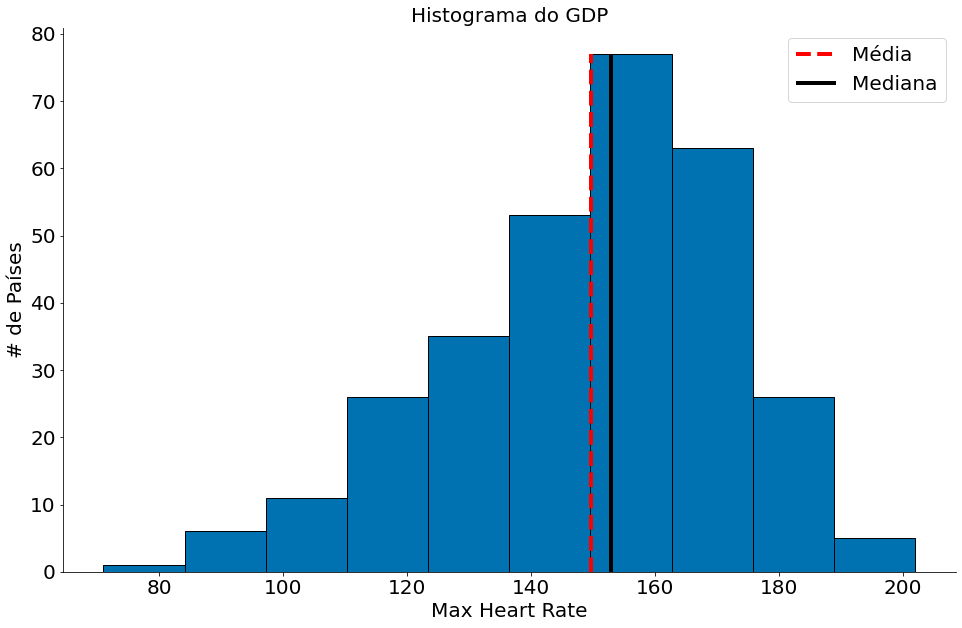

In [ ]:
# col = 'Age'
# col = 'Sex'
# col = 'Chest Pain'
# col = 'Resting Blood Pressure'
# col = 'Cholesterol'
# col = 'Fasting Blood Sugar'
# col = 'Resting ECG'
col = 'Max Heart Rate'
# col = 'Exercise Induced Angina'
# col = 'Oldpeak'
# col = 'Slope'
# col = 'CA'
# col = 'Thal'
# col = 'Target' # Quase Uniforme

x = df[col]

ymin = 0

n, bins, patches = plt.hist(x, bins=10, edgecolor='k')
plt.vlines(x.mean(), ymin, n.max(), label='Média', linestyles='--', edgecolor='k', color='red')
plt.vlines(x.median(), ymin, n.max(), label='Mediana', color='black')
plt.xlabel(col)
plt.ylabel('# de Países')
plt.title('Histograma do GDP')

plt.legend()

despine()

plt.show()

# 5. Testes de Hipóteses

## 1. Testes da Expectativa de Vida

Aqui faremos o bootstrap e calcularemos intervalos de confiança para mostrar uma possível correlação entre Expectativa de Vida e GDP.

Para isso, criaremos duas "classes", os países que possuem a Expectativa de Vida acima da média e aqueles que a possuem abaixo da média. Iremos ignorar a média já que a usamos para preencher os NaNs.

Como o leitor pode acompanhar, os ICs não se cruzam, o que significa, que, estatisticamente falando, o acaso não é capaz de explicar essa diferença.

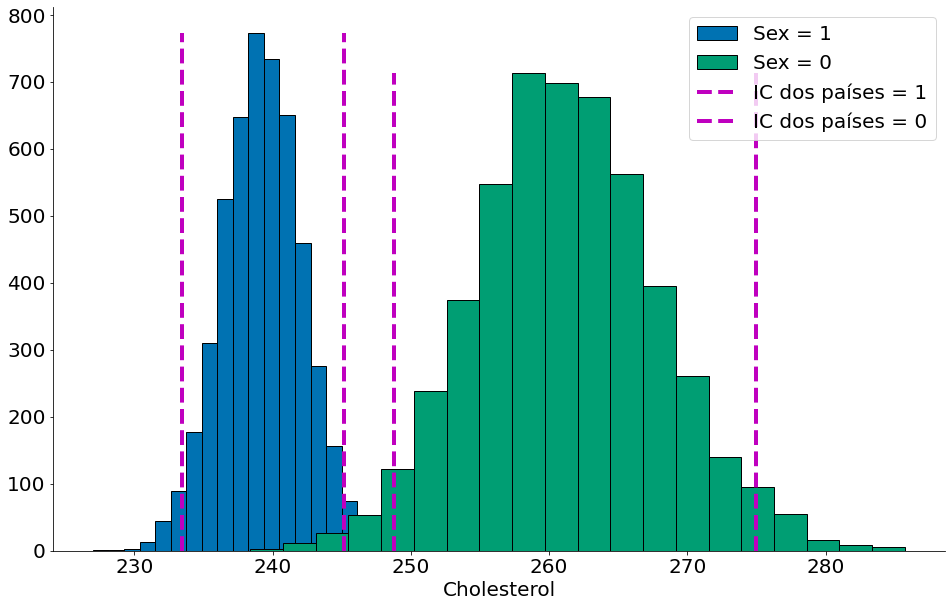

In [ ]:
# col0 = 'Resting Blood Pressure'
col0 = 'Cholesterol'
# col0 = 'Max Heart Rate'
# col0 = 'Target'

col = 'Sex'
# col = 'Chest Pain'
# col = 'Fasting Blood Sugar'
# col = 'Resting ECG'
# col = 'Exercise Induced Angina'
# col = 'Slope'
# col = 'CA'
# col = 'Thal'
# col = 'Target' # Quase Uniforme

ymin = 0
corte = df[col].unique()

for i in corte:
    filtro = df[col] == i
    df0 = df[col0][filtro]

    df0_mean = bootstrap_mean(df0)

    LI = np.percentile(df0_mean, 2.5)
    LS = np.percentile(df0_mean, 97.5)

    n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' = ' + str(i))

    maior = n.max()

    plt.vlines(LI, ymin, maior, linestyles='--', label='IC dos países' + ' = ' + str(i), color='m')
    plt.vlines(LS, ymin, maior, linestyles='--', edgecolor='m')

plt.xlabel(col0)
plt.ylabel('')
plt.title('')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

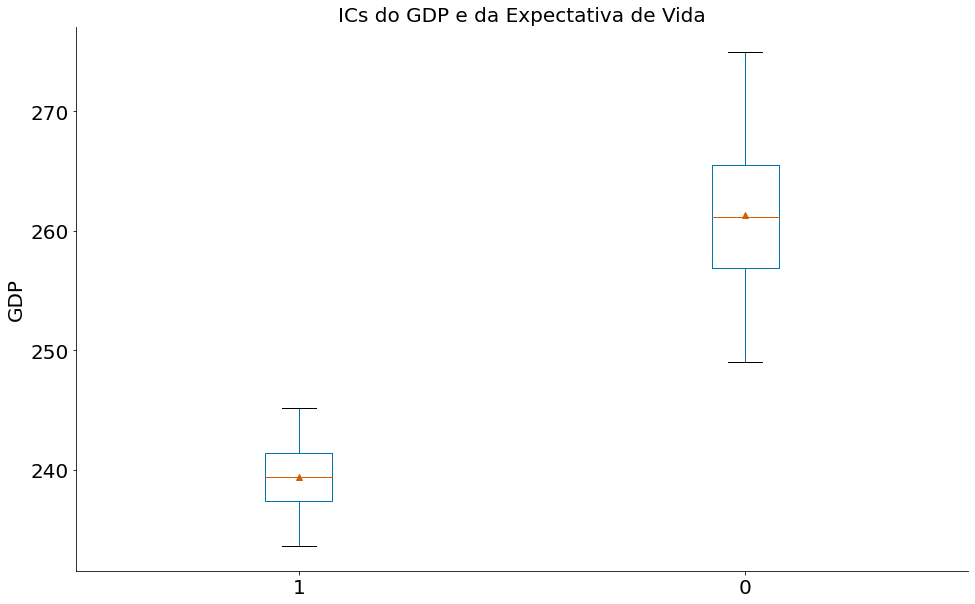

In [ ]:
corte = df[col].unique()
df1 = pd.DataFrame()

for i in corte:
    filtro = df[col] == i
    df0 = df[col0][filtro]

    df0_mean = bootstrap_mean(df0)

    df1[i] = df0_mean

df1.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)

plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

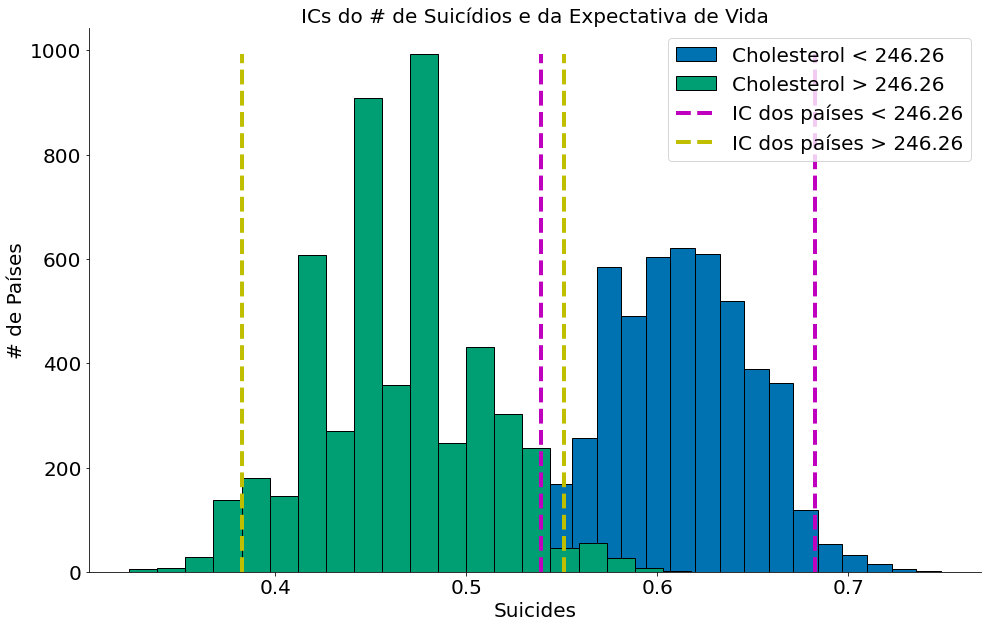

In [ ]:
col = 'Cholesterol'

col0 = 'Target'

corte = df[col].mean()

filtro = df[col] < corte
df0 = df[col0][filtro]

filtro = df[col] > corte
df1 = df[col0][filtro]

df0_mean = bootstrap_mean(df0)
df1_mean = bootstrap_mean(df1)

text = str(round(corte, ndigits=2))

LI0 = np.percentile(df0_mean, 2.5)
LS0 = np.percentile(df0_mean, 97.5)
LI1 = np.percentile(df1_mean, 2.5)
LS1 = np.percentile(df1_mean, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(df0_mean, bins=20, edgecolor='k', label=col + ' < ' + text)

maior.append(n.max())

n, bins, patches = plt.hist(df1_mean, bins=20, edgecolor='k', label=col + ' > ' + text)

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC dos países' + ' < ' + text, color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC dos países' + ' > ' + text, color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')
plt.xlabel('Suicides')
plt.ylabel('# de Países')
plt.title('ICs do # de Suicídios e da Expectativa de Vida')

plt.legend()

despine()

plt.show()

O BoxPlot nos permite ver o mesmo que o último gráfico de uma forma diferente.

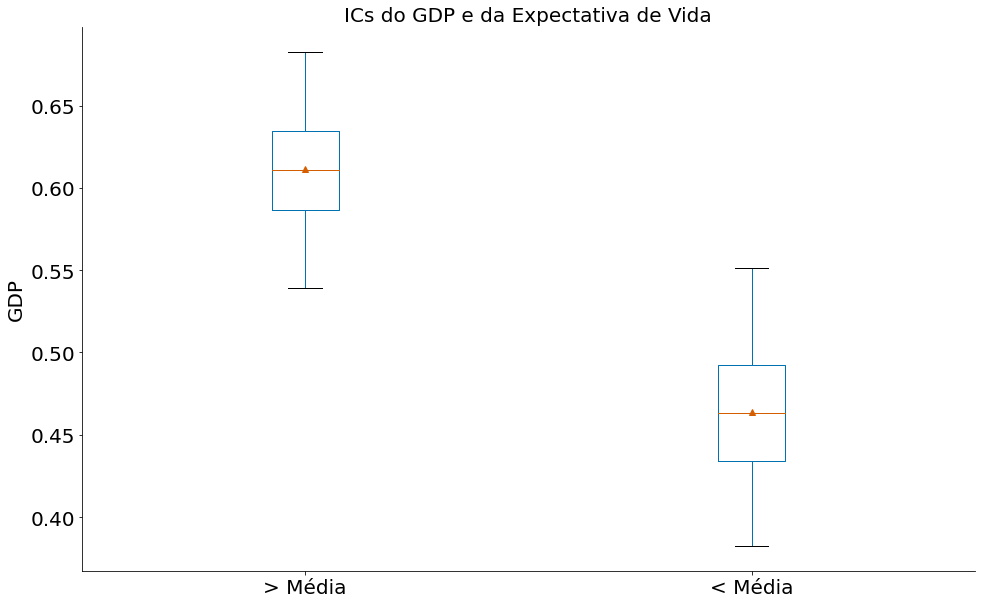

In [ ]:
df2 = pd.DataFrame()

df2['> Média'] = df0_mean
df2['< Média'] = df1_mean

df2.boxplot(grid=False, sym='', whis=[2.5, 97.5], showmeans=True)
plt.ylabel('GDP')
plt.title('ICs do GDP e da Expectativa de Vida')

despine()

plt.show()

# 9. Classificação Sexo

## 1. Pré-processamento de Dados

In [ ]:
# col = 'Age'
# col = 'Generation'
col = 'Target'

X = df.copy()
y = X[col]

X = X.drop(col, axis=1)

In [ ]:
# classes = y.unique()

# for i in range(len(classes)):
#     y[y == classes[i]] = i

In [ ]:
# label_encoder = LabelEncoder()
# y = label_encoder.fit_transform(y)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

mean_train = X_train.mean()
std_train = X_train.std(ddof=1)

Z_train = X_train.copy()
Z_train = Z_train - mean_train
Z_train = Z_train / std_train

Z_test = X_test.copy()
Z_test = Z_test - mean_train
Z_test = Z_test / std_train

## 2. Classificação

In [ ]:
skf = StratifiedKFold(n_splits=5)
fold = 1

for train_index, val_index in skf.split(Z_train, y_train):

    print('Fold:', fold)
    for k in [1, 3, 5, 7, 9, 11, 13, 15]:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(Z_train.values[train_index],
                  y_train.values[train_index])

        y_val = y_train.values[val_index]
        y_hat = model.predict(Z_train.values[val_index])

        # precision = np.mean(precision_score(y_val, y_hat, average=None))
        precision = precision_score(y_val, y_hat)
        print(k, 'Neighbors:', precision)
    print()
    print()
    fold += 1

Fold: 1
1 Neighbors: 0.75
3 Neighbors: 0.8076923076923077
5 Neighbors: 0.75
7 Neighbors: 0.7096774193548387
9 Neighbors: 0.7586206896551724
11 Neighbors: 0.7333333333333333
13 Neighbors: 0.7333333333333333
15 Neighbors: 0.7096774193548387


Fold: 2
1 Neighbors: 0.8181818181818182
3 Neighbors: 0.7307692307692307
5 Neighbors: 0.7307692307692307
7 Neighbors: 0.7037037037037037
9 Neighbors: 0.6785714285714286
11 Neighbors: 0.6785714285714286
13 Neighbors: 0.7307692307692307
15 Neighbors: 0.7037037037037037


Fold: 3
1 Neighbors: 0.7391304347826086
3 Neighbors: 0.8333333333333334
5 Neighbors: 0.8
7 Neighbors: 0.8
9 Neighbors: 0.8333333333333334
11 Neighbors: 0.76
13 Neighbors: 0.76
15 Neighbors: 0.8


Fold: 4
1 Neighbors: 0.7692307692307693
3 Neighbors: 0.8571428571428571
5 Neighbors: 0.8260869565217391
7 Neighbors: 0.8695652173913043
9 Neighbors: 0.8695652173913043
11 Neighbors: 0.9130434782608695
13 Neighbors: 0.875
15 Neighbors: 0.8076923076923077


Fold: 5
1 Neighbors: 0.857142857142857

In [ ]:
model = KNeighborsClassifier(n_neighbors=3)
model.fit(Z_train.values, y_train.values)

pscore_values0 = bootstrap_pscore(y_train.values, model.predict(Z_train.values))
pscore_values1 = bootstrap_pscore(y_test.values, model.predict(Z_test.values))

LI0 = np.percentile(r2_values0, 2.5)
LS0 = np.percentile(r2_values0, 97.5)
LI1 = np.percentile(r2_values1, 2.5)
LS1 = np.percentile(r2_values1, 97.5)

ymin = 0

maior = []

n, bins, patches = plt.hist(r2_values0, bins=30, label='Treino', edgecolor='k')

maior.append(n.max())

n, bins, patches = plt.hist(r2_values1, bins=30, label='Teste', edgecolor='k')

maior.append(n.max())

maior = np.max(maior)

plt.vlines(LI0, ymin, maior, linestyles='--', label='IC do PScore', color='m')
plt.vlines(LS0, ymin, maior, linestyles='--', edgecolor='m')
plt.vlines(LI1, ymin, maior, linestyles='--', label='IC do PScore', color='y')
plt.vlines(LS1, ymin, maior, linestyles='--', edgecolor='y')

plt.xlabel('Precision Score')
plt.title('ICs do Precision Score da Classificação KNN nos Grupos de Treino e de Teste')

plt.legend()

despine()

plt.show()

ValueError: ignored

# 10. Conclusão <a name="concl"></a>

O projeto criou oportunidades para o aprendizado de várias técnicas, conceitos e ferramentas do arcabouço de Ciência de Dados. Além do mais, foi possível perceber a importância de apresentar os dados de forma a aumentar a legibilidade deles pelo leitor.

Autor: Lucas S. Teles